In [1]:
import torch
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

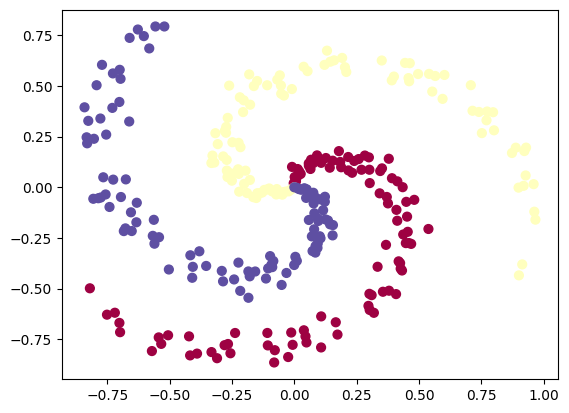

In [ ]:
import numpy as np
N = 100 
D = 2 
K = 3 
X = np.zeros((N*K,D)) 
y = np.zeros(N*K, dtype='uint8') 
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) 
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j

plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()


In [ ]:
x_sp = torch.from_numpy(X).type(torch.float)
y_sp = torch.from_numpy(y).type(torch.LongTensor)

In [5]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_sp, y_sp, test_size=0.2, random_state=42)

In [55]:
from torch import nn

class MultipleClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=2, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=3),
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

In [56]:
model = MultipleClassificationModel().to(device)

In [57]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
from helper_functions import accuracy_fn


torch.manual_seed(42)
epochs = 10000

y_train = y_train.long()
y_test = y_test.long()


x_train, x_test = x_train.to(device), x_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

for epoch in range(epochs):
    model.train()

    y_logit = model(x_train)
    loss = loss_fn(y_logit, y_train)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    y_pred = torch.argmax(y_logit, dim=1)
    acc = accuracy_fn(y_train, y_pred)



    model.eval()

    with torch.inference_mode():
        test_logit = model(x_test)
        test_pred = torch.argmax(test_logit, dim=1)
        test_loss = loss_fn(test_logit, y_test)
        test_acc = accuracy_fn(y_test, test_pred)

    if epoch % 500 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

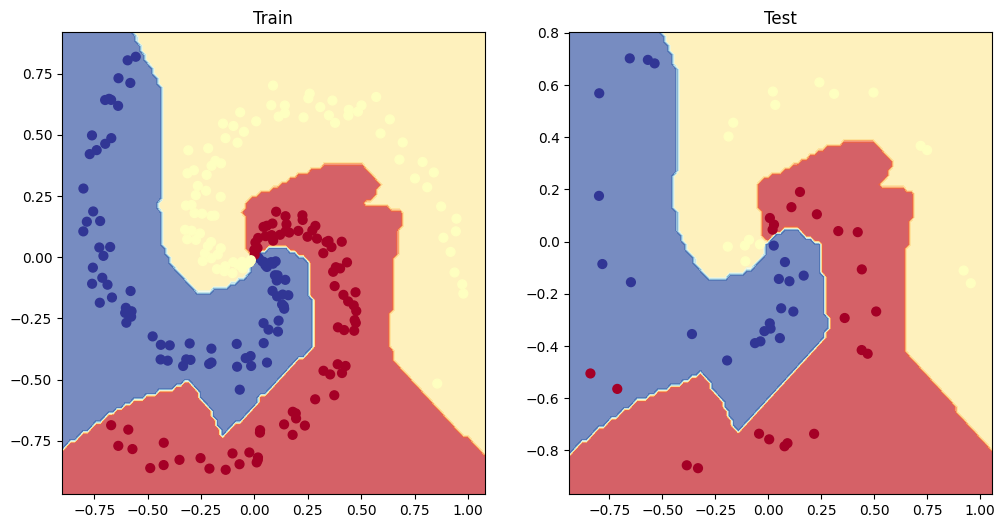

In [60]:
from helper_functions import plot_decision_boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, x_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, x_test, y_test)
